In [29]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [27,41,-12,2]
mapproj = cartopy.crs.PlateCarree()

datasets = ["cpc", "mswep", "chirps", "tamsat"]

In [16]:
sf = gpd.read_file("sf")

In [66]:
from taylorDiagram import TaylorDiagram, taylor_scores

# HighResMIP

## Spatial pattern (1990-2020 MAM climatology)

In [76]:
datasets = ["cpc", "mswep", "chirps", "tamsat"]

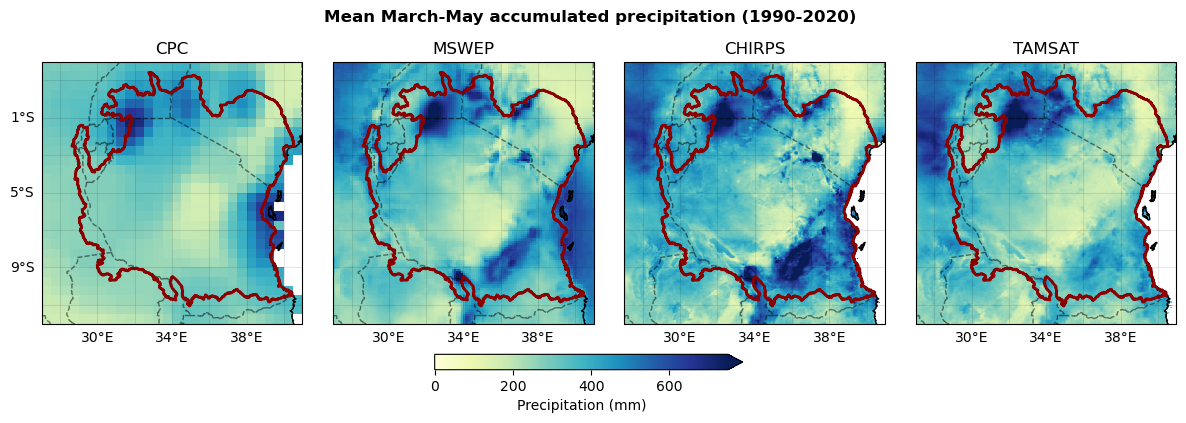

In [187]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)

for i in range(4):
    ds = datasets[i]
    da = xr.open_dataset("data/mam-climatology_"+ds+".nc").pr
    ax = axs[i]
    
    cbar = da.plot(ax = ax, vmin = 0, vmax = 750, cmap = "YlGnBu", add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
    # ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Mean March-May accumulated precipitation (1990-2020)", fontweight = "bold", y = 1.01)
plt.colorbar(cbar, ax = axs, location = "bottom", label = "Precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "max")

plt.savefig("fig/model-eval_obs_mam-climatology.png")

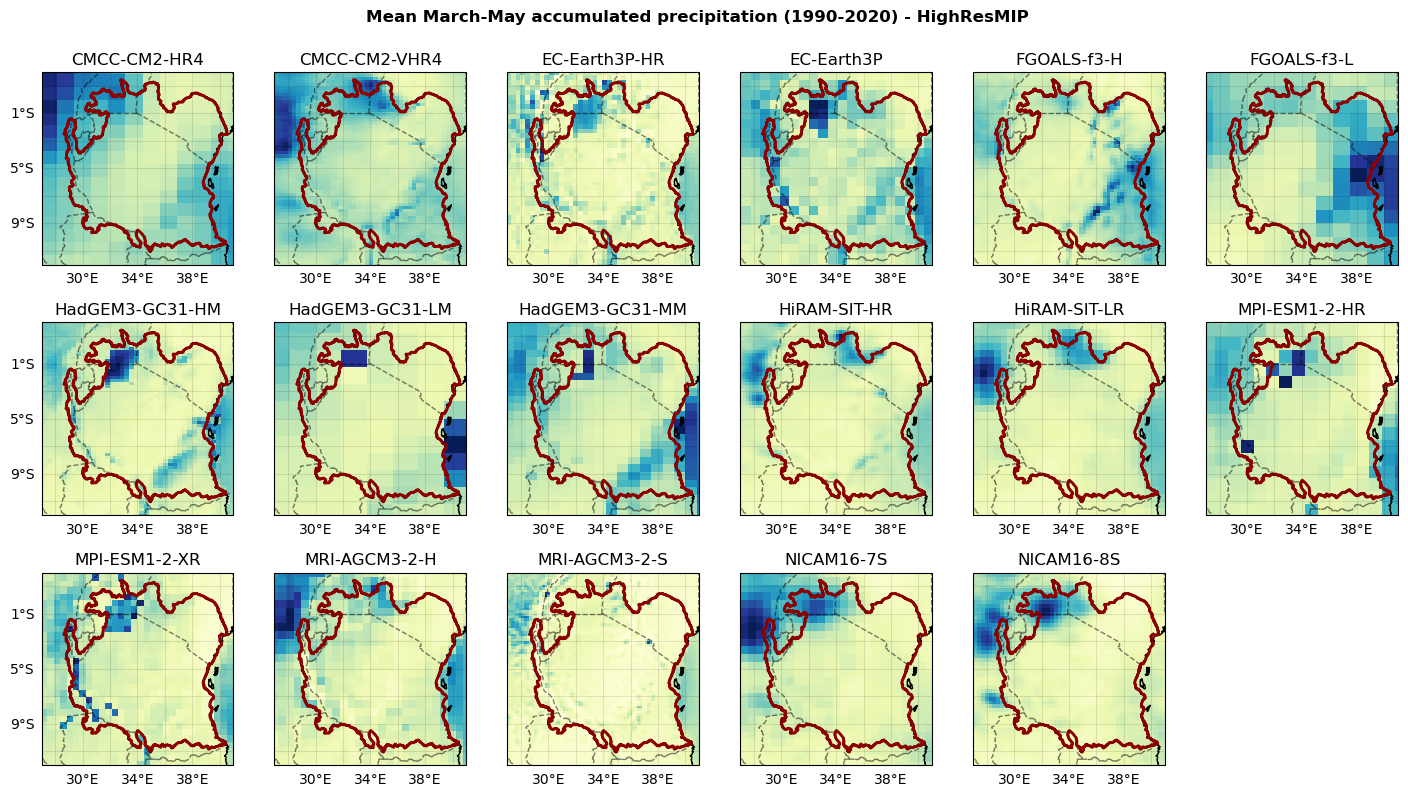

In [119]:
fl = sorted(glob.glob("data/highresMIP/*spatial*"))

fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (6*3,3*3), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01, hspace = 0.3)

for i in range(len(fl)):
    fnm = fl[i]
    mdl = fnm.split("_")[2]
    
    da = xr.open_dataset(fnm).pr
    ax = fig.axes[i]
    
    cbar = da.plot(ax = ax, vmin = 0, cmap = "YlGnBu", add_colorbar = False) 
    ax.set_title(mdl)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
        
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()

for ax in axs[:,0]: ax.gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Mean March-May accumulated precipitation (1990-2020) - HighResMIP", fontweight = "bold", y = 0.95)

plt.savefig("fig/model-eval_highresmip_mam-climatology.png")

### Taylor diagram

In [170]:
import xesmf as xe
sp_ref = xr.open_dataset("data/mam-climatology_tamsat.nc").sel(lon = slice(xn-2,xx+2), lat = slice(yn-2,yx+2))

# regrid models onto TAMSAT grid for direct comparison
fl = sorted(glob.glob("data/highresMIP/pr_spatial_*.nc"))
hrmip_regridded = []
sd_lowres = []
for fnm in fl:
    
    ds = xr.open_dataset(fnm)
    mdl = fnm.split("_")[2]
    regrid = xe.Regridder(ds, sp_ref, method = "conservative_normed", unmapped_to_nan = True)
    regridded = regrid(ds.pr).reset_coords(drop = True).squeeze().expand_dims(mdl = [mdl])
    
    sd_lowres.append(ds.pr.std())
    hrmip_regridded.append(regridded)
hrmip_regridded = xr.concat(hrmip_regridded, "mdl")

In [171]:
# regrid obs onto TAMSAT grid for direct comparison
fl = sorted([fnm for fnm in glob.glob("data/mam-climatology_*.nc") if not "tamsat" in fnm])
obs_regridded = []
sd_obs = []
for fnm in fl:
    
    ds = xr.open_dataset(fnm)
    regrid = xe.Regridder(ds, sp_ref, method = "conservative_normed", unmapped_to_nan = True)
    regridded = regrid(ds.pr).reset_coords(drop = True).squeeze().expand_dims(ds = [re.sub(".nc","",fnm).split("_")[-1]])
    
    sd_obs.append(ds.pr.std())
    obs_regridded.append(regridded)
obs_regridded = xr.concat(obs_regridded, "ds")

In [183]:
# get correlations & standard deviations (only use regridded data for correlations)
corr, sds, ref_sd = taylor_scores(hrmip_regridded, sp_ref.pr)
sds = [v.values for v in sd_lowres]

max_sd = max(np.ceil(max(sds) / ref_sd), 1.1)
min_corr = min(corrs)

obs_corrs, obs_sds, ref_sd  = taylor_scores(obs_regridded, sp_ref.pr)
obs_sds = [v.values for v in sd_obs]


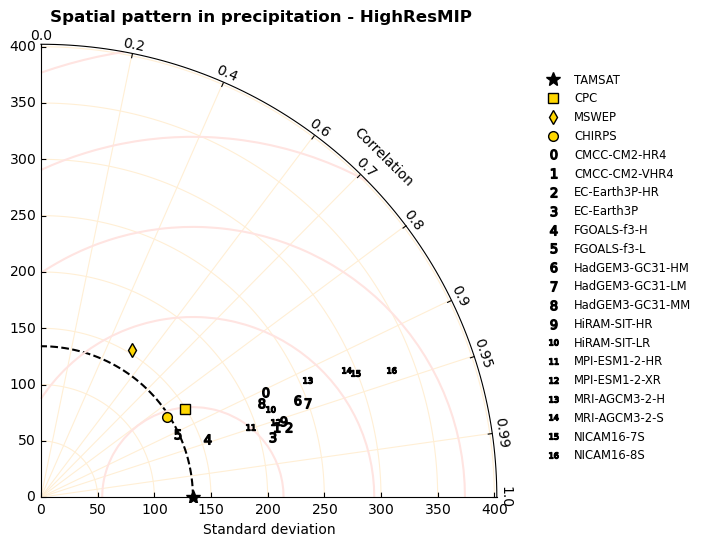

In [176]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "TAMSAT", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(obs_corrs)):
    if sc_obs.ds[i] == "tamsat": continue
    markers = ["s", "d", "o", "*"]
    td.add_sample(obs_sds[i], obs_corrs[i], marker = markers[i], ms = 7, ls = '', mfc = "gold", mec = "k", label = sc_obs.ds.values[i].upper(), zorder = 9)

for i in range(len(corrs)):
    
    mdl = sc_mdl.mdl.values[i]
    gcm_marker = "$"+str(i)+"$"
    rcm_colour = "k"
    
    # change border width depending on model resolution
    mew = 1
    if mdl.split("_")[0][-2:] == "22": mew = 1
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "k", label = mdl, mew = mew, zorder = 9)

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Spatial pattern in precipitation - HighResMIP", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/td_spatial-pattern_highresmip.png")

## Seasonal cycle (1990-2020 MAM climatology)

In [177]:
fl = sorted(glob.glob("data/highresMIP/pr_seasonal*"))

sc_obs = xr.concat([xr.open_dataset("data/daily-ts_org_"+ds+".nc").pr.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean().expand_dims(ds = [ds]) for ds in datasets], "ds").transpose().to_pandas()

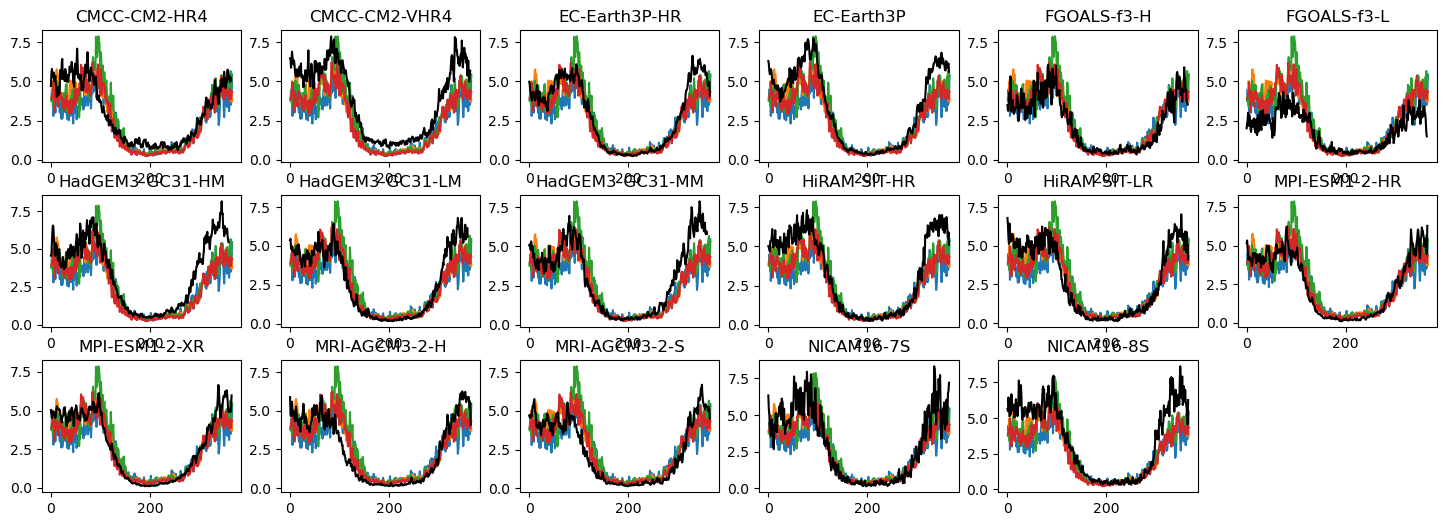

In [178]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (6*3, 3*2), dpi = 100)
plt.subplots_adjust(hspace = 0.25)

for i in range(len(fl)):
    ax = fig.axes[i]
    fnm = fl[i]
    
    mdl = fnm.split("_")[2]
    
    sc_obs.plot(ax = ax, legend = False)
    ax.plot(xr.open_dataset(fnm).pr, color = "k")
    
    ax.set_title(mdl)
    ax.set_xlabel("")
    
if len(fig.axes) > len(fl):
    for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()


### Taylor diagram

In [179]:
sc_obs = xr.concat([xr.open_dataset("data/daily-ts_org_"+ds+".nc").pr.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean().expand_dims(ds = [ds]) for ds in datasets], "ds")
sc_mdl = xr.concat([xr.open_dataset(fnm).pr.expand_dims(mdl = [fnm.split("_")[2]]) for fnm in sorted(glob.glob("data/highresMIP/pr_seasonal*"))], "mdl")

In [180]:
# get correlations & standard deviations
obs_corrs, obs_sds, ref_sd = taylor_scores(sc_obs, sc_obs.sel(ds = "tamsat", drop = True))
corrs, sds, ref_sd = taylor_scores(sc_mdl, sc_obs.sel(ds = "tamsat", drop = True))

max_sd = max(np.ceil(max(sds) / ref_sd), 1.1)
min_corr = min(corrs)

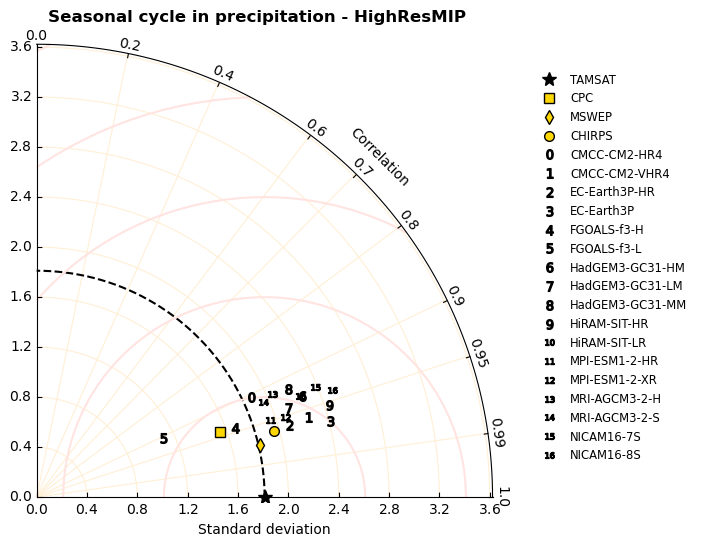

In [182]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "TAMSAT", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(obs_corrs)):
    if sc_obs.ds[i] == "tamsat": continue
    markers = ["s", "d", "o", "*"]
    td.add_sample(obs_sds[i], obs_corrs[i], marker = markers[i], ms = 7, ls = '', mfc = "gold", mec = "k", label = sc_obs.ds.values[i].upper(), zorder = 9)

for i in range(len(corrs)):
    
    mdl = sc_mdl.mdl.values[i]
    gcm_marker = "$"+str(i)+"$"
    rcm_colour = "k"
    
    # change border width depending on model resolution
    mew = 1
    if mdl.split("_")[0][-2:] == "22": mew = 1
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "k", label = mdl, mew = mew, zorder = 9)
    
    # highlight category each falls into
    # bg_col = {"good" : "green", "reasonable" : "orange", "bad" : "red"}[td_df.loc[mdl,"eval"]]
    # td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 11, ls = '', mfc = bg_col, mec = bg_col, label = "_", zorder = 8)

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation - HighResMIP", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/td_seasonal-cycle_highresmip_pr-org.png")